## Exercise: implement a second climate indicator

Now that you'we learned a bit of Ophidia, it's your turn to implement another climate indicator from the same set. In this section you're going to implement the Number of summer days (SU) indicator. With respect to the previous notebook, in this cases some of the arguments are missing and have to be completed with the proper value.

Starting from the daily maximum temperature (2096-2100) TX,
the Summer Days index is the number of days where $TX > T$ (T is  a reference temperature, e.g. 25°C)

Please refer again to [http://etccdi.pacificclimate.org/list_27_indices.shtml](http://etccdi.pacificclimate.org/list_27_indices.shtml) for further information.

Some hints to implement this indicator:

1. you can rely on the code from the previous example;
2. you can import the tasmax datacube as in the DTR indicator;
3. in order to get the days with temperature above 25°C (i.e., 298.15°K) you can use the predicate evaluation operation. This is the trickiest part of the indicator computation, an example of such operation is:

```python
mycube.apply(query="oph_predicate('OPH_FLOAT','OPH_INT',measure,'x-298.15','>0','1','0')")
```
The query parameter specifies the operation to be applied on each value within the datacube. In particular, it applies a predicate evaluation which converts all numbers bigger than 25 °C (the dataset contains Kelvin values, i.e. 298.15) to 1s and all the others to 0s. Additional information on this function is available on the [oph_predicate documentation](http://ophidia.cmcc.it/documentation/users/primitives/OPH_PREDICATE.html).

4. count the 1 days by using the reduce2 operator applied on yearly basis with sum operation;

5. to plot the map you can run a subset operation followed by the same plotting code used previously.

Let's start!

## 1. Run the analytics operators

As first step, let's connect to the Ophidia Server

In [1]:
from PyOphidia import cube
cube.Cube.setclient(read_env=True)

Current cdd is /
Current cwd is /


Import input NetCDF data set with maximum temperature in °K (from ```/home/ophidia/notebooks/tasmax_day_CMCC-CESM_rcp85_r1i1p1_20960101-21001231.nc```)

In [2]:
maxtemp = cube.Cube.importnc(
    src_path='/home/ophidia/notebooks/tasmax_day_CMCC-CESM_rcp85_r1i1p1_20960101-21001231.nc',
    measure='tasmax',
    imp_dim='time',
    ncores=2,
    description='Max Temps'
)

Identify the summer days: $\{day \mid TX(day) > 298.15\}$  with apply (we are basically creating a mask)

In [3]:
summerDays = maxtemp.apply(query="oph_predicate('OPH_FLOAT','OPH_INT',measure,'x-298.15','>0','1','0')")

Count the number of yearly summer days

In [4]:
count = summerDays.reduce2(
    operation="sum",
    dim="time",
    concept_level="y"
)

Subset on the first year

In [5]:
firstYear = count.subset(
    subset_filter=1, 
    subset_dims="time"
)

data = firstYear.export_array(show_time='yes')

## 2. Show results

Plot the indicator on a map

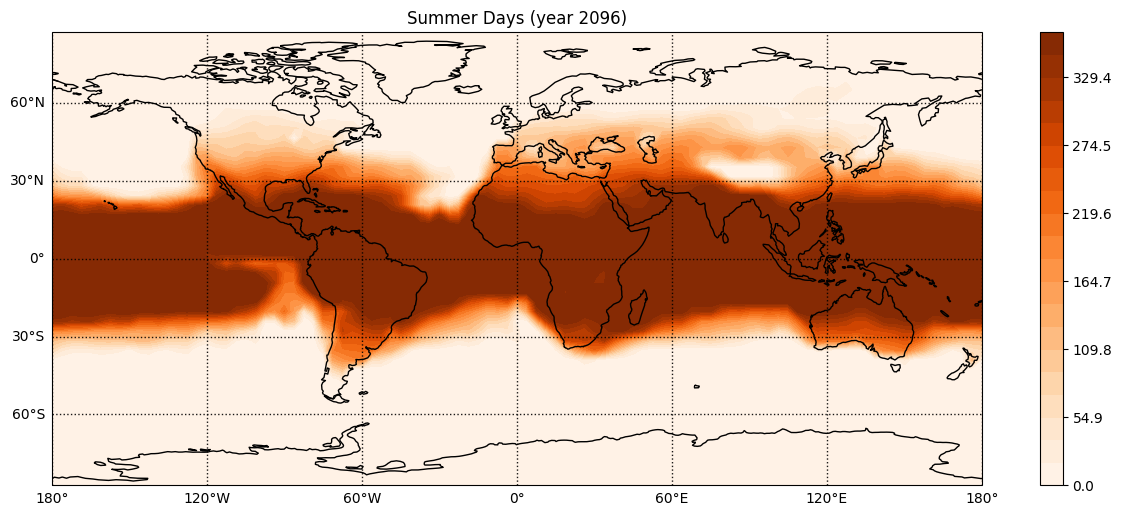

In [6]:
%matplotlib inline
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.util import add_cyclic_point
import numpy as np
import warnings
warnings.filterwarnings("ignore")

fig = plt.figure(figsize=(15, 6), dpi=100)

#Add Geo axes to the figure with the specified projection (PlateCarree)
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)

#Draw coastline and gridlines
ax.coastlines()

gl = ax.gridlines(crs=projection, draw_labels=True, linewidth=1, color='black', alpha=0.9, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False

lat = data['dimension'][0]['values'][ : ]
lon = data['dimension'][1]['values'][ : ]
var = data['measure'][0]['values'][ : ]
var = np.reshape(var, (len(lat), len(lon)))

#Wraparound points in longitude
var_cyclic, lon_cyclic = add_cyclic_point(var, coord=np.asarray(lon))
x, y = np.meshgrid(lon_cyclic,lat)

#Define color levels for color bar
levStep = (np.nanmax(var)-np.nanmin(var))/20
clevs = np.arange(np.nanmin(var),np.nanmax(var)+levStep,levStep)

#Set filled contour plot
cnplot = ax.contourf(x, y, var_cyclic, clevs, transform=projection,cmap=plt.cm.Oranges)
plt.colorbar(cnplot,ax=ax)

ax.set_aspect('auto', adjustable=None)

plt.title('Summer Days (year 2096)')
plt.show()

## 3. Final remarks

**NOTE:** You can find a sample implementation of this exercise in the *Examples* folder in the notebook [**Summer_Days**](../Examples/Summer_Days.ipynb)

To clear your workspace before running other notebooks

In [7]:
cube.Cube.deletecontainer(container="tasmax_day_CMCC-CESM_rcp85_r1i1p1_20960101-21001231.nc",force='yes')

You can now move to the last tutorial notebook for this session [**Linear Regression**](3-Linear_Regression.ipynb).